In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import ast
import cv2
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
GEN_PATH = 'drive/MyDrive/zt-trailer/'
IN_FOLDER = GEN_PATH + 'trailer-dataset/'
OUT_FOLDER = GEN_PATH + 'new-trailer-ds/'

# Data Extraction #

In [ ]:
# # get 1 frame/4 secs.
# # fps = 24 frames/sec.
# # hence, get 1 frame/96 frames

def save_collages(vidname, grid_images=25, frame_interval=80, fps=20, outpath=OUT_FOLDER):
  vidpath = IN_FOLDER + vidname + '.mp4'
  print(vidpath)

  vc = cv2.VideoCapture(vidpath)
  if not vc.isOpened():
    print(vidpath + " failed to open.")
    return

  vc.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
  if vc.get(cv2.CAP_PROP_FPS) < fps:
    print("Insufficient fps:", vc.get(cv2.CAP_PROP_FPS))
    return

  while (vc.get(cv2.CAP_PROP_FRAME_COUNT) < frame_interval * grid_images):
    print("Insufficient video length:", vc.get(cv2.CAP_PROP_FRAME_COUNT), "frames, needed", frame_interval * grid_images)
    frame_interval -= fps
    print("frame_interval lowered to 1 frame /", frame_interval, "frames")
    # return # some movies got skipped because of this

  start_idx = (vc.get(cv2.CAP_PROP_FRAME_COUNT) - (frame_interval * grid_images)) // 2
  total_collages = frame_interval

  start_idx = int(start_idx)
  total_collages = int(total_collages)
  for frame_start in tqdm(range(start_idx, start_idx + total_collages)):

    collage_img = []
    img_rows = []
    
    for frame_idx in range(grid_images):
      vc.set(cv2.CAP_PROP_POS_FRAMES, frame_start + (frame_idx * frame_interval))
      success, this_img = vc.read()
      if not success:
        print("Image capture failed at frame ", frame_start + (frame_idx * frame_interval))
        break

      this_img = cv2.resize(this_img, (50, 50))
      
      if len(img_rows) == 0:
        img_rows = this_img
      elif frame_idx % np.sqrt(grid_images) == 0:
        if len(collage_img) == 0:
          collage_img = img_rows
        else:
          collage_img = np.append(collage_img, img_rows, axis=0)
        img_rows = this_img
      else:
        img_rows = np.append(img_rows, this_img, axis=1)
    collage_img = np.append(collage_img, img_rows, axis=0)
    
    # print(frame_start - start_idx, end=" ")
    cv2.imwrite(outpath + vidname + ("0" + str(frame_start - start_idx) if (frame_start - start_idx < 10) else str(frame_start - start_idx)) + ".jpg", collage_img)

  print(vidpath, "| total collages:", total_collages)

# # commented because jeez if these got accidentally re-run
# train_df = pd.read_csv(GEN_PATH + "train_data.csv")
# test_df = pd.read_csv(GEN_PATH + "test_data.csv")

# for idx, row in train_df.iterrows():
#   save_collages(row['movie'])

# for idx, row in test_df.iterrows():
#   save_collages(row['movie'])

In [ ]:
# rechecking if any of the movies got skipped
while(True):
  all_movies = np.append(
      np.array((pd.read_csv(GEN_PATH + "train_data.csv"))['movie']),
      np.array((pd.read_csv(GEN_PATH + "test_data.csv"))['movie'])
      )
  files = np.unique(np.array([x[x.rfind("/") + 1:x.rfind(".jpg") - 2] for x in glob(OUT_FOLDER + "*.jpg")]))

  all_movies = np.sort(all_movies)
  files = np.sort(files)

  if not np.array_equal(all_movies, files):
    missing_movies = [mov for mov in all_movies if mov not in files]
    print(missing_movies)

    for m in missing_movies: save_collages(m)
  else:
    break
print("Check passed.")

Check passed.


# Data Reorganization #
*   For Pytorch's ImageFolder
*   Trying the six main genres first (Adventure, Comedy, Scifi, Action, Horror, Romance) 

In [ ]:
# since test_data.csv already contains all 22 genres, i.e. already stratified, just use that
genres = pd.read_csv(GEN_PATH + 'test_data.csv').drop("Unnamed: 0", axis=1)['genre'].apply(ast.literal_eval).apply(pd.Series).stack().unique()
genres

array(['adventure', 'comedy', 'scifi', 'martialarts', 'action', 'spy',
       'horror', 'disaster', 'romance'], dtype=object)

In [ ]:
# trying the six main genres only, see if that works
genres = np.delete(genres, [3, 5, 7])
genres

array(['adventure', 'comedy', 'scifi', 'action', 'horror', 'romance'],
      dtype=object)

In [ ]:
TRAIN_FOLDER_PATH = OUT_FOLDER + 'train/'
TEST_FOLDER_PATH = OUT_FOLDER + 'test/'

In [ ]:
train_df = pd.read_csv(GEN_PATH + "train_data.csv").drop("Unnamed: 0", axis=1)
train_df['genre'] = train_df['genre'].apply(ast.literal_eval)

for g in genres:
  if not os.path.exists(TRAIN_FOLDER_PATH + g):
    os.mkdir(TRAIN_FOLDER_PATH + g)
  else:
    print(TRAIN_FOLDER_PATH + g, "already exists, so the data must already be there. Skip!")
    continue    

  movies = np.array(train_df.loc[train_df['genre'].apply(lambda x: g in x), 'movie'])
  for mov in movies:
    files = glob(OUT_FOLDER + mov + "*.jpg")
    print(mov, g)
    for f in tqdm(files):
      fn = f[f.rfind("/") + 1:]
      shutil.copyfile(f, TRAIN_FOLDER_PATH + g + "/" + fn)
    print()

  0%|          | 0/80 [00:00<?, ?it/s]

advcom-rio adventure


  0%|          | 0/80 [00:00<?, ?it/s]


adventuresinzambezia adventure


  0%|          | 0/80 [00:00<?, ?it/s]


epic adventure


  0%|          | 0/80 [00:00<?, ?it/s]


gulliverstravels adventure


  0%|          | 0/80 [00:00<?, ?it/s]


indianajonesandthelastcrusade adventure


  0%|          | 0/80 [00:00<?, ?it/s]


jackthegiantslayer adventure


  0%|          | 0/80 [00:00<?, ?it/s]


journeytothewestthedemonsstrikeback adventure


  0%|          | 0/80 [00:00<?, ?it/s]


jumanjithenextlevel adventure


  0%|          | 0/80 [00:00<?, ?it/s]


lifeofpi adventure


  0%|          | 0/80 [00:00<?, ?it/s]


pussinboots adventure


  0%|          | 0/160 [00:00<?, ?it/s]


themummy adventure


 18%|█▊        | 14/80 [00:00<00:00, 134.31it/s]


themummytombofthedragonemperor adventure


  0%|          | 0/80 [00:00<?, ?it/s]


advcom-rio comedy


  0%|          | 0/80 [00:00<?, ?it/s]


billandtedfacethemusic comedy


  0%|          | 0/80 [00:00<?, ?it/s]


centralintelligence comedy


  0%|          | 0/80 [00:00<?, ?it/s]


crazyrichasians comedy


  0%|          | 0/80 [00:00<?, ?it/s]


downsizing comedy


  0%|          | 0/80 [00:00<?, ?it/s]


enterthefatdragon comedy


  0%|          | 0/80 [00:00<?, ?it/s]


forbiddencitycop comedy


  0%|          | 0/80 [00:00<?, ?it/s]


getsmart comedy


  0%|          | 0/80 [00:00<?, ?it/s]


goosebumps2hauntedhalloween comedy


  0%|          | 0/80 [00:00<?, ?it/s]


grownups comedy


  0%|          | 0/80 [00:00<?, ?it/s]


gulliverstravels comedy


  0%|          | 0/80 [00:00<?, ?it/s]


hailcaesar comedy


  0%|          | 0/80 [00:00<?, ?it/s]


holidate comedy


  0%|          | 0/80 [00:00<?, ?it/s]


home comedy


  0%|          | 0/80 [00:00<?, ?it/s]


hottubtimemachine comedy


  0%|          | 0/60 [00:00<?, ?it/s]


johnnyenglish comedy


  0%|          | 0/80 [00:00<?, ?it/s]


journeytothewestthedemonsstrikeback comedy


  0%|          | 0/80 [00:00<?, ?it/s]


jumanjithenextlevel comedy


  0%|          | 0/80 [00:00<?, ?it/s]


keepingupwiththejoneses comedy


  0%|          | 0/80 [00:00<?, ?it/s]


kingsmanthesecretservice comedy


  0%|          | 0/80 [00:00<?, ?it/s]


kungfuhustle comedy


  0%|          | 0/80 [00:00<?, ?it/s]


lalaland comedy


  0%|          | 0/80 [00:00<?, ?it/s]


lastchristmas comedy


  0%|          | 0/80 [00:00<?, ?it/s]


mrandmrssmith comedy


  0%|          | 0/60 [00:00<?, ?it/s]


mrsdoubtfire comedy


  0%|          | 0/80 [00:00<?, ?it/s]


rushhour2 comedy


  0%|          | 0/80 [00:00<?, ?it/s]


schoolofrock comedy


  0%|          | 0/80 [00:00<?, ?it/s]


shaunofthedead comedy


  0%|          | 0/80 [00:00<?, ?it/s]


thedeaddontdie comedy


  0%|          | 0/80 [00:00<?, ?it/s]


thespies comedy


  0%|          | 0/80 [00:00<?, ?it/s]


truememoirsofaninternationalassassin comedy


  0%|          | 0/80 [00:00<?, ?it/s]


vampireacademy comedy


  0%|          | 0/80 [00:00<?, ?it/s]


2012 scifi


  0%|          | 0/80 [00:00<?, ?it/s]


alitabattleangel scifi


  0%|          | 0/80 [00:00<?, ?it/s]


annihilation scifi


  0%|          | 0/80 [00:00<?, ?it/s]


billandtedfacethemusic scifi


  0%|          | 0/80 [00:00<?, ?it/s]


coldskin scifi


  0%|          | 0/80 [00:00<?, ?it/s]


deepbluesea2 scifi


  0%|          | 0/80 [00:00<?, ?it/s]


divergent scifi


  0%|          | 0/80 [00:00<?, ?it/s]


downsizing scifi


  0%|          | 0/80 [00:00<?, ?it/s]


equals scifi


  0%|          | 0/80 [00:00<?, ?it/s]


geostorm scifi


  0%|          | 0/80 [00:00<?, ?it/s]


her scifi


  0%|          | 0/80 [00:00<?, ?it/s]


highrise scifi


  0%|          | 0/80 [00:00<?, ?it/s]


home scifi


  0%|          | 0/80 [00:00<?, ?it/s]


hottubtimemachine scifi


  0%|          | 0/80 [00:00<?, ?it/s]


iorigins scifi


  0%|          | 0/80 [00:00<?, ?it/s]


madmaxfuryroad scifi


  0%|          | 0/80 [00:00<?, ?it/s]


oxygen scifi


  0%|          | 0/80 [00:00<?, ?it/s]


passengers scifi


  0%|          | 0/80 [00:00<?, ?it/s]


seafever scifi


  0%|          | 0/80 [00:00<?, ?it/s]


sharknado scifi


  0%|          | 0/80 [00:00<?, ?it/s]


skyline scifi


  0%|          | 0/80 [00:00<?, ?it/s]


thehungergames scifi


  0%|          | 0/80 [00:00<?, ?it/s]


themazerunner scifi


  0%|          | 0/80 [00:00<?, ?it/s]


voyagers scifi


  0%|          | 0/80 [00:00<?, ?it/s]


alitabattleangel action


  0%|          | 0/80 [00:00<?, ?it/s]


casinoroyale action


  0%|          | 0/80 [00:00<?, ?it/s]


centralintelligence action


  0%|          | 0/80 [00:00<?, ?it/s]


dayofthedeadbloodline action


  0%|          | 0/80 [00:00<?, ?it/s]


divergent action


  0%|          | 0/80 [00:00<?, ?it/s]


epic action


  0%|          | 0/80 [00:00<?, ?it/s]


extraction action


  0%|          | 0/80 [00:00<?, ?it/s]


fastandfurious4 action


  0%|          | 0/80 [00:00<?, ?it/s]


furious7 action


  0%|          | 0/80 [00:00<?, ?it/s]


indianajonesandthelastcrusade action


  0%|          | 0/80 [00:00<?, ?it/s]


ipman4thefinale action


  0%|          | 0/80 [00:00<?, ?it/s]


jasonbourne action


  0%|          | 0/80 [00:00<?, ?it/s]


keepingupwiththejoneses action


  0%|          | 0/80 [00:00<?, ?it/s]


kickboxervengeance action


  0%|          | 0/80 [00:00<?, ?it/s]


madmaxfuryroad action


  0%|          | 0/80 [00:00<?, ?it/s]


masterztheipmanlegacy action


  0%|          | 0/240 [00:00<?, ?it/s]


missionimpossible action


  0%|          | 0/80 [00:00<?, ?it/s]


missionimpossiblefallout action


  0%|          | 0/80 [00:00<?, ?it/s]


missionimpossibleroguenation action


  0%|          | 0/80 [00:00<?, ?it/s]


mortalkombat action


  0%|          | 0/80 [00:00<?, ?it/s]


mrandmrssmith action


  0%|          | 0/80 [00:00<?, ?it/s]


thefirstpurge action


  0%|          | 0/80 [00:00<?, ?it/s]


thehungergames action


  0%|          | 0/160 [00:00<?, ?it/s]


themummy action


  0%|          | 0/80 [00:00<?, ?it/s]


themummytombofthedragonemperor action


  0%|          | 0/80 [00:00<?, ?it/s]


thepurgeelectionyear action


  0%|          | 0/80 [00:00<?, ?it/s]


truememoirsofaninternationalassassin action


  0%|          | 0/80 [00:00<?, ?it/s]


underwaterbloodwars action


  0%|          | 0/80 [00:00<?, ?it/s]


annihilation horror


  0%|          | 0/80 [00:00<?, ?it/s]


coldskin horror


  0%|          | 0/80 [00:00<?, ?it/s]


dayofthedeadbloodline horror


  0%|          | 0/80 [00:00<?, ?it/s]


deepbluesea2 horror


  0%|          | 0/80 [00:00<?, ?it/s]


goosebumps2hauntedhalloween horror


  0%|          | 0/80 [00:00<?, ?it/s]


ouija horror


  0%|          | 0/80 [00:00<?, ?it/s]


seafever horror


  0%|          | 0/80 [00:00<?, ?it/s]


shaunofthedead horror


  0%|          | 0/80 [00:00<?, ?it/s]


theconjuring horror


  0%|          | 0/80 [00:00<?, ?it/s]


thecurseoflallorona horror


  0%|          | 0/80 [00:00<?, ?it/s]


thedeaddontdie horror


  0%|          | 0/80 [00:00<?, ?it/s]


thefirstpurge horror


  0%|          | 0/80 [00:00<?, ?it/s]


thenun horror


  0%|          | 0/80 [00:00<?, ?it/s]


thepurgeelectionyear horror


  0%|          | 0/80 [00:00<?, ?it/s]


underwaterbloodwars horror


  0%|          | 0/80 [00:00<?, ?it/s]


vampireacademy horror


  0%|          | 0/80 [00:00<?, ?it/s]


awalktoremember romance


  0%|          | 0/80 [00:00<?, ?it/s]


crazyrichasians romance


  0%|          | 0/80 [00:00<?, ?it/s]


equals romance


  0%|          | 0/80 [00:00<?, ?it/s]


her romance


  0%|          | 0/80 [00:00<?, ?it/s]


holidate romance


  0%|          | 0/80 [00:00<?, ?it/s]


iorigins romance


  0%|          | 0/80 [00:00<?, ?it/s]


lalaland romance


  0%|          | 0/80 [00:00<?, ?it/s]


lastchristmas romance


  0%|          | 0/80 [00:00<?, ?it/s]


passengers romance


  0%|          | 0/80 [00:00<?, ?it/s]


rememberme romance


  0%|          | 0/80 [00:00<?, ?it/s]


thefaultinourstars romance


  0%|          | 0/80 [00:00<?, ?it/s]


thenotebook romance


100%|██████████| 80/80 [00:17<00:00,  4.70it/s]

In [ ]:
test_df = pd.read_csv(GEN_PATH + "test_data.csv").drop("Unnamed: 0", axis=1)
test_df['genre'] = test_df['genre'].apply(ast.literal_eval).apply(lambda x: "-".join(x))

for g in genres:
  if not os.path.exists(TEST_FOLDER_PATH + g):
    os.mkdir(TEST_FOLDER_PATH + g)
  else:
    print(TRAIN_FOLDER_PATH + g, "already exists, so the data must already be there. Skip!")
    continue

  movies = np.array(test_df.loc[test_df['genre'] == g, 'movie'])
  for mov in movies:
    files = glob(OUT_FOLDER + mov + "*.jpg")
    print(mov, g)
    for f in tqdm(files):
      fn = f[f.rfind("/") + 1:]
      shutil.copyfile(f, TEST_FOLDER_PATH + g + "/" + fn)
    print()

  0%|          | 0/80 [00:00<?, ?it/s]

theseventhadventuresofsinbad adventure


  0%|          | 0/80 [00:00<?, ?it/s]


theedgeofseventeen comedy


  0%|          | 0/80 [00:00<?, ?it/s]


womb scifi


  0%|          | 0/80 [00:00<?, ?it/s]


thefastandthefurioustokyodrift action


  0%|          | 0/80 [00:00<?, ?it/s]


thering horror


  0%|          | 0/80 [00:00<?, ?it/s]


thephotograph romance


100%|██████████| 80/80 [00:15<00:00,  5.04it/s]

# And Now, The Hard Part #

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

### Channel-wise Data Normalization ###

In [ ]:
# # getting the mean and standard deviation for channel-wise data normalization

# # commented because jeez if these got accidentally re-run

# img_size = (-1, -1)

# files = glob(OUT_FOLDER + "*.jpg")

# RD_total = 0
# GR_total = 0
# BL_total = 0

# # to calculate the means
# for f in tqdm(files):
#   img = cv2.imread(f)

#   if img_size[0] == -1:
#     img_size = img.shape

#   img = np.transpose(img, axes=[2, 0, 1])
#   img = img / 255

#   # OpenCV is BGR
#   BL_total += img[0].sum()
#   GR_total += img[1].sum()
#   RD_total += img[2].sum()

# # total number of elements
# numel = len(files) * img_size[0] * img_size[1]

# # means
# mR = RD_total / numel
# mG = GR_total / numel
# mB = BL_total / numel

# RD_diff_total = 0
# GR_diff_total = 0
# BL_diff_total = 0

# # calculate the stds
# for f in tqdm(files):
#   img = cv2.imread(f)

#   img = np.transpose(img, axes=[2, 0, 1])
#   img = img / 255

#   # OpenCV is BGR
#   BL_diff_total += ((img[0] - mB) * (img[0] - mB)).sum()
#   GR_diff_total += ((img[1] - mG) * (img[1] - mG)).sum()
#   RD_diff_total += ((img[2] - mR) * (img[2] - mR)).sum()

# # stds
# stdR = RD_diff_total / numel
# stdG = GR_diff_total / numel
# stdB = BL_diff_total / numel

# # to pandas and save we go!
# stat_df = pd.DataFrame({
#     'COLOUR': ['RED', 'GREEN', 'BLUE'], 
#     'MEAN': [mR, mG, mB], 
#     'STD': [stdR, stdG, stdB]
#     })
# stat_df.to_csv(OUT_FOLDER + "stats.csv")
# stat_df

In [ ]:
stat_df = pd.read_csv(OUT_FOLDER + "stats.csv")
means = tuple((stat_df['MEAN'].apply(pd.Series))[0])
stds = tuple((stat_df['STD'].apply(pd.Series))[0])

means, stds

((0.2080979337694621, 0.2009254203652357, 0.18535293684749013),
 (0.0588759382916108, 0.05593377067812413, 0.05176317219261626))

### Data ###


In [ ]:
tfms = tt.Compose([
                   tt.RandomCrop(250, padding=5, padding_mode='reflect'),
                   tt.RandomHorizontalFlip(),
                   tt.ToTensor(),
                   # tt.Normalize(means, stds, inplace=True)
                   ])

vtfms = tt.Compose([
                   #tt.RandomCrop(250, padding=10, padding_mode='reflect'),
                   #tt.RandomHorizontalFlip(),
                   tt.ToTensor(),
                   # tt.Normalize(means, stds, inplace=True)
                   ])

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
batch_size = 16
device = get_default_device()
print('device:', device)

train_ds = ImageFolder(OUT_FOLDER + "/train", tfms)
valid_ds = ImageFolder(OUT_FOLDER + "/test", vtfms)

train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True), device)
valid_dl = DeviceDataLoader(DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True), device)

train_ds.classes, valid_ds.classes, len(train_ds), len(valid_ds), len(train_dl), len(valid_dl)

device: cuda


(['action', 'adventure', 'comedy', 'horror', 'romance', 'scifi'],
 ['action', 'adventure', 'comedy', 'horror', 'romance', 'scifi'],
 618,
 30)

### Model ###

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.7f}, train_loss: {:.7f}, val_loss: {:.7f}, val_acc: {:.7f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def conv_block(in_channels, out_channels, pool=False):
  layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
  ]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(
        conv_block(128, 128),
        conv_block(128, 128)
    )

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(
        conv_block(512, 512),
        conv_block(512, 512)
    )

    self.classifier1 = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten()
    )

    self.classifier2 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(25088, 2048),
        nn.Dropout(0.25),
        nn.Linear(2048, num_classes)
    )

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    
    out = self.classifier1(out) # output after flattened 4x25088
    out = self.classifier2(out)

    return out

In [ ]:
model = to_device(ResNet9(3, len(genres)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training ###



In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  # sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

  best_acc = 0
  best_tloss = 99
  patience = 3
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []

    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      # sched.step()
      # sched.step(result['val_loss'])

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

    if result['val_acc'] > best_acc:
      best_acc = result['val_acc']
      torch.save(model.state_dict(), GEN_PATH + 'trailerModel5.pth')
      print("Model saved:", GEN_PATH + 'trailerModel5.pth')
    
    if result['train_loss'] >= best_tloss:
      patience -= 1
    else:
      best_tloss = result['train_loss']
      patience = 3

    if patience == 0:
      patience = 3
      max_lr /= 10
      print("new lr:", max_lr)
      optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.0729166641831398, 'val_loss': 1.792617678642273}]

In [ ]:
epochs = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.AdamW

In [ ]:
%%time
history += fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    grad_clip=grad_clip,
    weight_decay=weight_decay,
    opt_func=opt_func
)

Epoch [0], last_lr: 0.0000001, train_loss: 0.8406922, val_loss: 1.3773814, val_acc: 0.4895833
Model saved: drive/MyDrive/zt-trailer/trailerModel5.pth
Epoch [1], last_lr: 0.0000001, train_loss: 0.8288861, val_loss: 1.3430908, val_acc: 0.5479167
Model saved: drive/MyDrive/zt-trailer/trailerModel5.pth
Epoch [2], last_lr: 0.0000001, train_loss: 0.8386177, val_loss: 1.3788513, val_acc: 0.5291666
Epoch [3], last_lr: 0.0000001, train_loss: 0.8306664, val_loss: 1.4460437, val_acc: 0.5458333
Epoch [4], last_lr: 0.0000001, train_loss: 0.8334312, val_loss: 1.3567363, val_acc: 0.5312500
new lr: 1e-08
Epoch [5], last_lr: 0.0000000, train_loss: 0.8205700, val_loss: 1.3698164, val_acc: 0.5104167
Epoch [6], last_lr: 0.0000000, train_loss: 0.8416910, val_loss: 1.4338298, val_acc: 0.5312500
Epoch [7], last_lr: 0.0000000, train_loss: 0.8278655, val_loss: 1.3851572, val_acc: 0.5270833
Epoch [8], last_lr: 0.0000000, train_loss: 0.8104334, val_loss: 1.3877608, val_acc: 0.5354167
Epoch [9], last_lr: 0.000000

### Visualizations ###

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of Epochs')
  plt.show()

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of Epochs')
  plt.show()

def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch No.')
  plt.show()

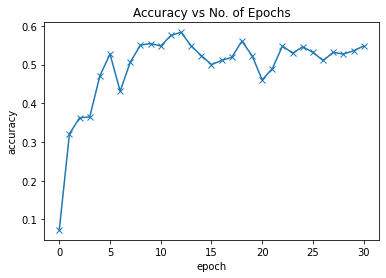

In [ ]:
plot_accuracies(history)

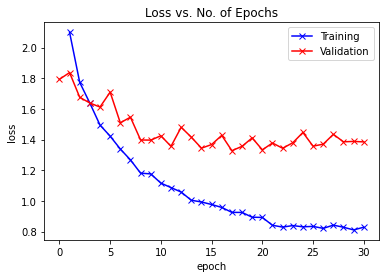

In [ ]:
plot_losses(history)

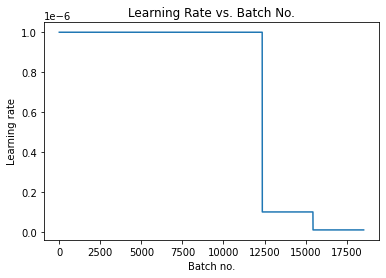

In [ ]:
plot_lrs(history)

### Individual Predictions ###

In [ ]:
batch_size = 16
device = get_default_device()
print('device:', device)

train_ds = ImageFolder(OUT_FOLDER + "/train", tfms)
valid_ds = ImageFolder(OUT_FOLDER + "/test", vtfms)

train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True), device)
valid_dl = DeviceDataLoader(DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True), device)

train_ds.classes, valid_ds.classes, len(train_ds), len(valid_ds), len(train_dl), len(valid_dl)

In [ ]:
test_df = pd.read_csv(GEN_PATH + "test_data.csv").drop("Unnamed: 0", axis=1)

movies = np.array(test_df['movies'])
for mov in movies:
  files = glob(OUT_FOLDER + mov + "*.jpg")
  print(mov, g)
  for f in tqdm(files):
    fn = f[f.rfind("/") + 1:]
    shutil.copyfile(f, OUT_FOLDER + 'indivtesting/' + g + "/" + fn)
    break

test_ds = ImageFolder(OUT_FOLDER + "/indivtesting")